In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from omegaconf import OmegaConf
from dinov2.models.vision_transformer import vit_large
from dinov2.models import build_model_from_cfg
from dinov2.utils.utils import load_pretrained_weights

# Attention Maps

Dinov2 (and Dino) technics are built upon vision transformers, which slice
images into patches that are then embedded into new dimensional spaces.  
To those patches some special tokens are added, tipycally the \<cls> token
which concatenates the information from all the other tokens, and in the case of
Dinov2 architecture **\<registry_tokens>** are added, allowing the model to discharge some additional information that it would otherwise put on specifically
unspecific patches ([see here for the article](https://arxiv.org/abs/2309.16588))

The model that we trained on the white cells has 4 registry tokens and a cls token, let's look at their attention maps, which are the attention between those tokens and the other patches in the last attention layer.

## Load the model

In [4]:
from cell_similarity.configs import default_config

# Load the cfg file used to train and build the model
cfg_path = "/home/guevel/OT4D/cell_similarity/vitl_register/config.yaml"
default_cfg = OmegaConf.create(default_config)
cfg = OmegaConf.load(cfg_path)
cfg = OmegaConf.merge(cfg, default_cfg)

# Load the model
model, _ = build_model_from_cfg(cfg, only_teacher=True)
path_model = "/home/guevel/OT4D/cell_similarity/vitl_register/eval/training_124999/teacher_checkpoint.pth"
load_pretrained_weights(model, path_model, "teacher")

In [5]:
model.eval()
model.cuda()

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0): BlockChunk(
      (0-5): 6 x NestedTensorBlock(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=1024, out_features=3072, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1024, out_features=1024, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): SwiGLUFFNFused(
          (w12): Linear(in_features=1024, out_features=5472, bias=True)
          (w3): Linear(in_features=2736, out_features=1024, bias=True)
        )
        (ls2): LayerScale()
        (drop_path2): Identity()
      )
    )
    (1): BlockC

## Make the dataset

We make a dataset that will load all the images from the barcelona dataset with some transformations to resize the images (more patches for a smoother visualisation),
and some normalizations.  

In [6]:
patch_h, patch_w = 40, 40

transform = transforms.Compose([
    transforms.GaussianBlur(9, sigma=(0.1, 2.0)),
    transforms.Resize((patch_h * 14, patch_w * 14)),
    transforms.CenterCrop((patch_h * 14, patch_w * 14)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)

data_path = "/home/manon/classification/data/Single_cells/barcelona"
dataset = ImageFolder(data_path, transform=transform)

## Get the attention maps

To do so we retrieve the intermediate features before the final output of the model, as well as the last layer of the model.  
We then use an added feature of the attention layers to retrieve the attn maps instead of the normal attention outputs.  

In [7]:
last_layer = [blk for blk_chunk in model.blocks for blk in blk_chunk][-1]
last_layer.attn

MemEffAttention(
  (qkv): Linear(in_features=1024, out_features=3072, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=1024, out_features=1024, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)

In [9]:
last_layer = [blk for blk_chunk in model.blocks for blk in blk_chunk][-1]

def get_attn(img, layer):

    img = img.unsqueeze(0).cuda()
    with torch.no_grad():
        patches = model.get_intermediate_layers(img, return_class_token=True, n=2)
    img_inter, cls_inter, registry_inter = (patches)[0]

    cls_token = torch.cat([cls_inter.unsqueeze(1), img_inter], dim=1)
    registry_token = torch.cat([registry_inter, img_inter], dim=1)
    num_registry = registry_inter.shape[1]
    
    with torch.no_grad():
        cls_attn = layer.attn.forward(cls_token, return_attn=True)[0, :, 0, 1:]
        registry_attn = layer.attn.forward(registry_token, return_attn=True)[0, :, :num_registry, num_registry:]
    return cls_attn.cpu(), registry_attn.cpu()

## Plot the results

In [13]:
from PIL import Image

k=150

def plot_cls(k, save=False):
    img, img_path = dataset[k][0], dataset.imgs[k][0]
    cls_attn, registry_attn = get_attn(img, last_layer)
    
    cls_attn = torch.sum(cls_attn, dim=0).reshape((patch_h, patch_w))
    
    img_or = np.array(Image.open(img_path)) 
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    
    ax[0].imshow(img_or)
    ax[0].axis("off")
    ax[0].set_title("Original image")
    ax[1].imshow(cls_attn)
    ax[1].axis("off")
    ax[1].set_title("Attention map <cls> token")

    if save:
        plt.savefig("attention_map_cls.png")
    plt.show()


def plot_register(k, save=False):
    img, img_path = dataset[k][0], dataset.imgs[k][0]
    cls_attn, registry_attn = get_attn(img, last_layer)
    num_register = registry_attn.shape[1]
    
    cls_attn = torch.sum(cls_attn, dim=0).reshape((patch_h, patch_w))
    registry_attn = torch.sum(registry_attn, dim=0).reshape((num_register, patch_h, patch_w))
    
    img_or = np.array(Image.open(img_path)) 
    fig, ax = plt.subplots(1, 2+num_register, figsize=(20, 5))
    
    ax[0].imshow(img_or)
    ax[0].axis("off")
    ax[0].set_title("Original image")
    ax[1].imshow(cls_attn)
    ax[1].axis("off")
    ax[1].set_title("Attention map <cls> token")
    for i in range(2, 2+num_register):
        ax[i].imshow(registry_attn[i-2, :, :])
        ax[i].axis("off")
        ax[i].set_title(f"Attention map <registry_{i-2}>")

    if save:
        plt.savefig("attention_map_registers.png")
    plt.show()

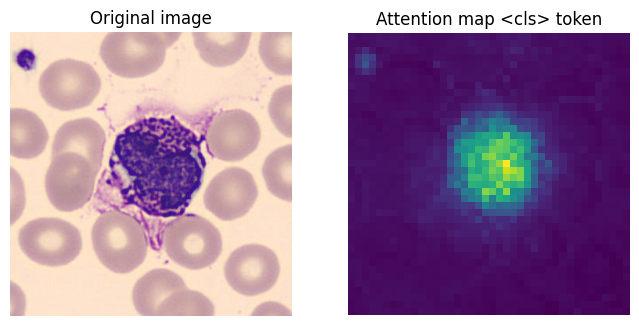

In [14]:
plot_cls(1996, save=True)

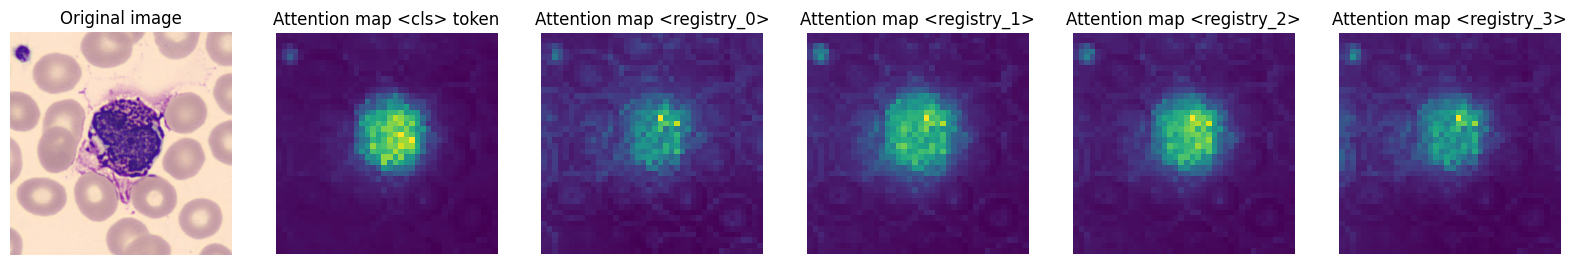

In [15]:
plot_register(1996, save=True)

## Next steps : look how the attention map looked for the previous model (that did not have any register tokens)